In [65]:
%%capture setup_output
%run 'setup.ipynb'

In [108]:
import pytorch_lightning as pl
import torch
import pandas as pd
import numpy as np
import os
import sys
import pdb
import seaborn as sns

from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt

from src.data_processing import load_and_process_data
from src.UserEmbeddingDataset import UserEmbeddingDataset
from src.UserEmbeddingModel import UserEmbeddingModel
from src.plot_results import plot_regression_results, plot_average_error_by_bins, plot_prediction_distribution
from src.metrics.evaluate import evaluate_regression, compute_median_80_percent_error

In [89]:
# Define dataset file path
file_path = '../results/removed_outliers.parquet'
df = pd.read_parquet(file_path)

# Define features and target variables
# removed 'c_chargingmethod','c_chargingtype' 'mean_dep_time','latitude', 'longitude',  'start_datetime'
relevant_features = ['c_vin', 'c_realstartsoc', 'weekday_numerical', 'is_weekend',
                     'mean_consumption', 'mean_duration', 'latitude', 'longitude',
                     'start_hour', 'start_day', 'is_home_spot', 'is_location_one',
                     'start_datetime', 'delta_soc_real', 'plugin_duration_hr']

target = 'delta_soc_real' #, 'delta_soc_real', plugin_duration_hr

df = df[relevant_features]

In [ ]:
# Training batch size
batch_size = 2048

# Dimension of the user embedding layer
embedding_dim = 16

In [90]:
print(len(df))
df = df.dropna()
print(len(df))

8637446
8631511


In [91]:
# Sort the DataFrame by 'c_vin' and 'start_datetime'
df = df.sort_values(by=['c_vin', 'start_datetime'])
# Add new features for previous session plugin_duration_hr and delta_soc_real
df['prev_plugin_duration_hr'] = df.groupby('c_vin')['plugin_duration_hr'].shift(1)
df['prev_delta_soc_real'] = df.groupby('c_vin')['delta_soc_real'].shift(1)

df['prev_plugin_duration_hr'] = df['prev_plugin_duration_hr'].fillna(df['plugin_duration_hr'])
df['prev_delta_soc_real'] = df['prev_delta_soc_real'].fillna(df['delta_soc_real'])

In [92]:
label_encoder = LabelEncoder()
df['c_vin_encoded'] = label_encoder.fit_transform(df['c_vin'])
df = df.drop(columns=['c_vin'])

features = ['c_realstartsoc', 'weekday_numerical', 'is_weekend',
            'mean_consumption', 'mean_duration', 'latitude', 'longitude',
            'start_hour', 'start_day', 'is_home_spot', 'is_location_one',
            'prev_plugin_duration_hr', 'prev_delta_soc_real']


feature_scaler = StandardScaler()
target_scaler = StandardScaler()

df[features] = feature_scaler.fit_transform(df[features])
df[[target]] = target_scaler.fit_transform(df[[target]])

In [93]:
df['c_vin_encoded']
num_users = df['c_vin_encoded'].nunique()
print('Number of users: ', num_users)

27573


In [94]:
X = df[features]
y = df[[target]]
c_vin_index = df[['c_vin_encoded']]

X_train, X_test, y_train, y_test, vin_train, vin_test = train_test_split(
    X, y, c_vin_index, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test, vin_val, vin_test = train_test_split(
    X_test, y_test, vin_test, test_size=0.5, random_state=42)

In [95]:
# Make sure the dimensions are the same for different sets
print(f"X_train: {len(X_train)}, X_val: {len(X_val)}, X_test: {len(X_test)}")
print(f"y_train: {len(y_train)}, y_val: {len(y_val)}, y_test: {len(y_test)}")
print(f"vin_train: {len(vin_train)}, vin_val: {len(vin_val)}, vin_test: {len(vin_test)}")

6905208 863151 863152
6905208 863151 863152
6905208 863151 863152


In [96]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device)

Device:  cuda


In [97]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
vin_train = np.array(vin_train)
vin_val = np.array(vin_val)
vin_test = np.array(vin_test)

(6905208, 13) (6905208, 1) (6905208, 1)


In [ ]:
# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
vin_train_tensor = torch.tensor(vin_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
vin_test_tensor = torch.tensor(vin_test, dtype=torch.long).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
vin_val_tensor = torch.tensor(vin_val, dtype=torch.long).to(device)

In [99]:
input_dim = X_train.shape[1]

In [100]:
# Create datasets and dataloaders
train_dataset = UserEmbeddingDataset(X=X_train_tensor, user_ids=vin_train_tensor, y=y_train_tensor)
val_dataset = UserEmbeddingDataset(X=X_val_tensor, user_ids=vin_val_tensor, y=y_val_tensor)
test_dataset = UserEmbeddingDataset(X=X_test_tensor, user_ids=vin_test_tensor, y=y_test_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [101]:
# Set up logger
csv_logger = CSVLogger("logs", name="dnn-soc")

checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints-dnn',
    filename='best_checkpoint_soc',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, mode="min")

In [79]:
model = UserEmbeddingModel(input_dim=input_dim,
                           embedding_dim=embedding_dim,
                           num_users=num_users,
                           dropout_prob=0.1)
trainer = pl.Trainer(max_epochs=100,
                     logger=csv_logger,
                     callbacks=[checkpoint_callback, early_stopping])
# Uncomment the line below to start training
# trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [102]:
checkpoint_path = 'checkpoints-dnn/best_checkpoint_soc.ckpt'
model = UserEmbeddingModel.load_from_checkpoint(checkpoint_path,
                                                input_dim=input_dim,
                                                embedding_dim=embedding_dim,
                                                num_users=num_users)

In [103]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5113903284072876     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5113903284072876}]

In [82]:
model.eval()
model.to(device)
with torch.no_grad():
    y_pred = model(vin_test_tensor, X_test_tensor)

In [105]:
y_pred_original = target_scaler.inverse_transform(y_pred.to('cpu'))
y_test_original = target_scaler.inverse_transform(y_test_tensor.to('cpu'))

In [39]:
metrics = evaluate_regression(y_test_original, y_pred_original)
print("Evaluation Metrics:", metrics)

Evaluation Metrics: {'MAE': 12.280997111236164, 'MSE': 251.5334454600432, 'RMSE': 15.859805971702277, 'R2': 0.48859363685201207, 'MAPE': 101.81146395283011, 'Positive MAPE ': 20.854098671891677, 'Negative MAPE ': -197.06761216243402, 'MNE': -12.984951647216542, 'MPE': 11.682712322467111, 'Pinball Loss': 6.245409980853412, 'Coverage Accuracy': 45.942767769217404}


In [40]:
median_80_error = compute_median_80_percent_error(y_test_original, y_pred_original)
print(f"Median 80% Average Error: {median_80_error}")

Median 80% Average Error: 9.630264778815764


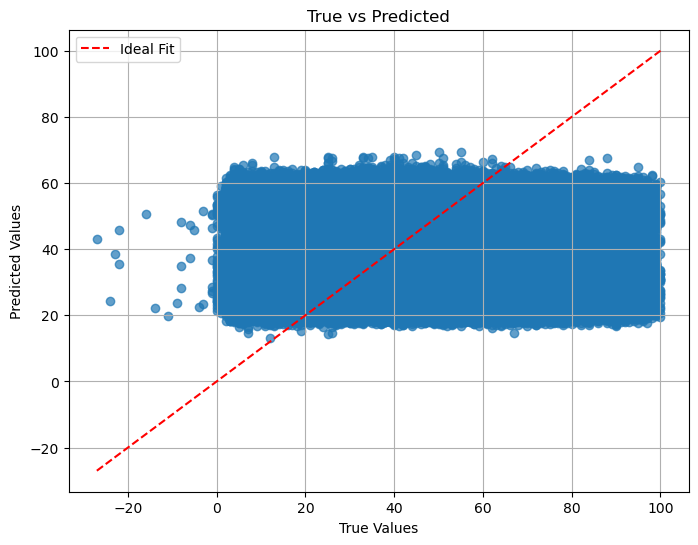

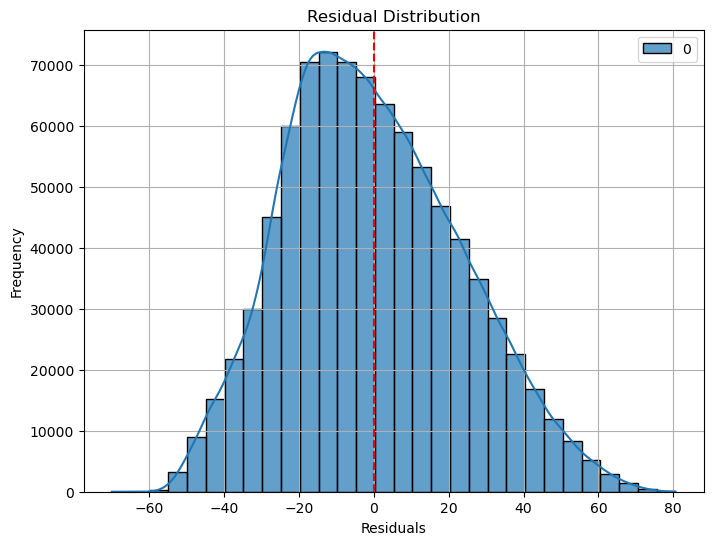

In [111]:
# Set savefig=True to save the plots
savefig=False
plot_regression_results(y_test_original, y_pred_original, savefig=savefig, name='dnn-soc')

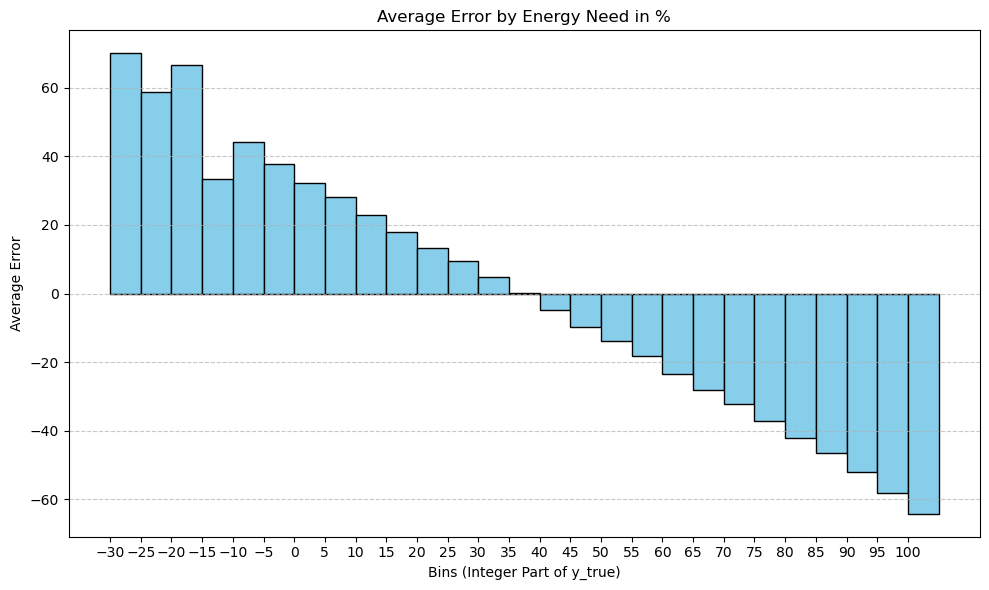

,bin,count,avg_error
0,-30,1.0,70.046323
1,-25,4.0,58.780536
2,-20,1.0,66.661791
3,-15,2.0,33.494172
4,-10,6.0,44.119188
5,-5,55.0,37.903867
6,0,22827.0,32.347656
7,5,66402.0,28.288130
8,10,69011.0,22.994240
9,15,82412.0,17.873502


In [109]:
plot_average_error_by_bins(y_test_original, y_pred_original, bin_size=5, savefig=savefig, name='dnn-soc')

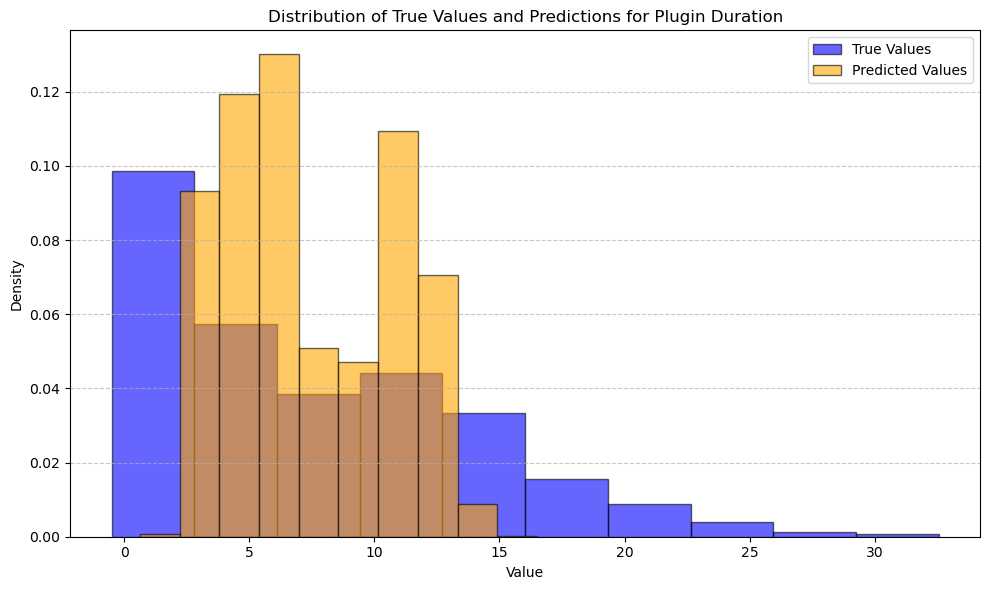

In [88]:
plot_prediction_distribution(y_test_original, y_pred_original, savefig=savefig, name='dnn-dur')